# Training
This notebook trains the model with 3 fold cross validation.

# Imports and setup

In [1]:
import sys
# Need this to load the packages correct in Fox ml nodes.
sys.path.append("/fp/homes01/u01/ec-krimhau/.local/lib/python3.11/site-packages")

In [2]:
import os
import gc
import copy
import time
import random
import string
import joblib

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW
from transformers import DataCollatorWithPadding
import datasets
# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import wandb

In [3]:
# Load .env file
%load_ext dotenv
%dotenv /fp/homes01/u01/ec-krimhau/thesis_code/.env

In [4]:
os.environ['WANDB_NOTEBOOK_NAME'] = '/fp/homes01/u01/ec-krimhau/thesis_code/jira/priority_model/highest_vs_rest/deberta/01_training/01_train_highest_vs_rest.ipynb'
# Get wandb api key from .env file
wandb_api_key = os.getenv('WANDB_API_KEY')
# Login to wandb to track results
wandb.login(key = wandb_api_key) # API key

wandb: Currently logged in as: haugerud-kristian (krimhau). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /fp/homes01/u01/ec-krimhau/.netrc


True

In [5]:
# Function to generate a unique random identifier for experiment tracking.
def id_generator(size=12, chars=string.ascii_lowercase + string.digits):
    return ''.join(random.SystemRandom().choice(chars) for _ in range(size))


HASH_NAME = id_generator(size=12)
print(HASH_NAME)


oz8unm2wtpw6


In [6]:
# Config for the model
CONFIG = {"seed": 42,
          "epochs": 10,
          "model_name": "microsoft/deberta-v3-base",
          "train_batch_size": 8,
          "valid_batch_size": 16,
          "max_length": 512,
          "learning_rate": 1e-5,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 3,
          "n_accumulate": 1,
          "num_classes": 2,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          "hash_name": HASH_NAME,
          "_wandb_kernel": "deb",
          }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])
CONFIG['group'] = f'{HASH_NAME}-Baseline'


In [7]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [8]:
# Splits the data into train and test. Validation is done using KFold.
def train_test_split(df, train_percent=.85, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    train = df.iloc[perm[:train_end]]
    test = df.iloc[perm[train_end:]]
    return train, test

In [9]:
priority_df = pd.read_csv("../csv/highest_vs_rest_balanced_jira.csv" , index_col = 0)
priority_df

,text_clean,label,class_original
class,,,
highest,when we do range query on simple keys it does ...,1,Highest
highest,unhandledpromiserejectionwarning unhandled pro...,1,Highest
rest,the fabricunittestdaily branch failing intermi...,0,Medium
rest,as a system operator i want to receive alerts ...,0,Medium
rest,there is no support in datasourcetransactionma...,0,Medium
...,...,...,...
rest,once i have imported a widget into the store i...,0,Low
rest,the spec defines an axiom of a ie singleton li...,0,Medium
rest,to have an history on master of all csvs setup...,0,Medium


In [10]:
# Drop NaN values and reset index of dataframe
priority_df = priority_df[priority_df['text_clean'].notna()]
priority_df = priority_df.rename(columns={'text_clean': 'text'})
priority_df = priority_df.reset_index()
priority_df.drop(columns=["class", "class_original"], inplace=True)

In [11]:
priority_df

,text,label
0,when we do range query on simple keys it does ...,1
1,unhandledpromiserejectionwarning unhandled pro...,1
2,the fabricunittestdaily branch failing intermi...,0
3,as a system operator i want to receive alerts ...,0
4,there is no support in datasourcetransactionma...,0
...,...,...
110711,once i have imported a widget into the store i...,0
110712,the spec defines an axiom of a ie singleton li...,0
110713,to have an history on master of all csvs setup...,0
110714,there are still some changes expected to be me...,1


In [12]:
train_hp_df , test_hp_df = train_test_split(priority_df)

In [13]:
df = train_hp_df

In [14]:
df.reset_index(inplace = True)

In [15]:
df.drop(columns=["index"], inplace=True)

In [16]:
df

,text,label
0,currently we are using usrshareelasticsearch a...,0
1,its been over hrs since the mirror has been up...,0
2,there has been discussion on the mailing lists...,0
3,when elytron client tries to obtain clientconf...,1
4,need to be able to release all items at once v...,1
...,...,...
94103,this was discussed in the pr args will be kept...,0
94104,the take and filter kernels do not currently s...,0
94105,currently pointing to out of date links names ...,1
94106,the chaincode build image relies on accessing ...,1


In [17]:
gkf = GroupKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(gkf.split(X=df, groups=df.text)):
    df.loc[val_ , "kfold"] = int(fold)
    
df["kfold"] = df["kfold"].astype(int)


In [18]:
df.groupby('kfold')['label'].value_counts()


kfold  label
0      1        15814
       0        15556
1      0        15783
       1        15586
2      0        15685
       1        15684
Name: count, dtype: int64

In [19]:
df

,text,label,kfold
0,currently we are using usrshareelasticsearch a...,0,2
1,its been over hrs since the mirror has been up...,0,0
2,there has been discussion on the mailing lists...,0,0
3,when elytron client tries to obtain clientconf...,1,1
4,need to be able to release all items at once v...,1,2
...,...,...,...
94103,this was discussed in the pr args will be kept...,0,0
94104,the take and filter kernels do not currently s...,0,2
94105,currently pointing to out of date links names ...,1,2
94106,the chaincode build image relies on accessing ...,1,2


In [20]:
class HP_Dataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        self.targets = df['label'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        return {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'target': self.targets[index]
        }

In [21]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])


In [22]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [23]:
class HP_Model(nn.Module):
    def __init__(self, model_name):
        super(HP_Model, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.config = AutoConfig.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.pooler = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.pooler(out.last_hidden_state, mask)
        out = self.drop(out)
        outputs = self.fc(out)
        return outputs

In [24]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

In [25]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score



In [27]:
def all_classification_report(y_true, y_pred, target_names = ['Non_HP', 'HP'], digits=4):
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names = target_names, digits=4))
    
    accuracy =round(accuracy_score(y_true, y_pred),4)
    print("Accuracy =",  accuracy)
    f1score = round(f1_score(y_true, y_pred),4)
    print("F1_score =", f1score)

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Non_HP', 'HP'])
    ax.yaxis.set_ticklabels(['Non_HP', 'HP'])
    
    return  accuracy , f1score
    
    

In [28]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    dataset_size = 0
    running_loss = 0.0
    
    y_pred = []
    y_true = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        

        predictions = torch.argmax(outputs, dim=-1).flatten().tolist()
        
        target = targets.tolist()

        y_pred.extend(predictions)
        y_true.extend(target)
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,LR=optimizer.param_groups[0]['lr'])   
    
    
    accuracy, f1score = all_classification_report(y_true,y_pred)
    gc.collect()
    
    return epoch_loss , accuracy , f1score

In [29]:
from codecarbon import track_emissions
@track_emissions()
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, accuracy , f1score = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
      
        history['Valid accuracy'].append(accuracy)
        history['Valid f1score'].append(f1score)



        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        wandb.log({"Valid Accuracy": accuracy})
        wandb.log({"Valid F1_score": f1score})


        
        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            run.summary["Best Loss"] = best_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"{HASH_NAME}-Loss-Fold-{fold}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history


In [30]:
def prepare_loaders(fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = HP_Dataset(df_train, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])
    valid_dataset = HP_Dataset(df_valid, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], collate_fn=collate_fn, 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], collate_fn=collate_fn,
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [31]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

====== Fold: 0 ======


wandb: Tracking run with wandb version 0.16.4
wandb: Run data is saved locally in /fp/homes01/u01/ec-krimhau/thesis_code/jira/priority_model/highest_vs_rest/deberta/01_training_epoch_test/wandb/run-20240321_150504-kfhrimqj
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run oz8unm2wtpw6-fold-0
wandb: ⭐️ View project at https://wandb.ai/krimhau/HP_results_Jira_High_vs_rest_results
wandb: 🚀 View run at https://wandb.ai/krimhau/HP_results_Jira_High_vs_rest_results/runs/kfhrimqj
[codecarbon INFO @ 15:05:12] [setup] RAM Tracking...
[codecarbon INFO @ 15:05:12] [setup] GPU Tracking...
[codecarbon INFO @ 15:05:12] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 15:05:12] [setup] CPU Tracking...
[codecarbon WARNING @ 15:05:12] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 15:05:14] We saw that you have a AMD EPYC 7642 48-Core Processor but we don't know it. Please contact us.
[codecarbon INFO @ 15:05:14] CPU Model on constant consumption 

[INFO] Using GPU: NVIDIA A100-PCIE-40GB



  1%|▉                                                                                                                 | 65/7842 [00:14<22:05,  5.87it/s, Epoch=1, LR=9.63e-6, Train_Loss=0.719][codecarbon INFO @ 15:05:33] Energy consumed for RAM : 0.000400 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 15:05:33] Energy consumed for all GPUs : 0.000725 kWh. Total GPU Power : 174.03009514144878 W
[codecarbon INFO @ 15:05:33] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:05:33] 0.001303 kWh of electricity used since the beginning.
  2%|█▉                                                                                                               | 131/7842 [00:29<27:18,  4.71it/s, Epoch=1, LR=8.56e-6, Train_Loss=0.691][codecarbon INFO @ 15:05:48] Energy consumed for RAM : 0.000800 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 15:05:48] Energy consumed for all GPUs : 0.001475 kWh. Total GPU Power : 179.85389977489567 W
[codecarbon INFO @ 15:05:48] Ene

Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6930    0.6891    0.6910     15556
          HP     0.6958    0.6996    0.6977     15814

    accuracy                         0.6944     31370
   macro avg     0.6944    0.6944    0.6944     31370
weighted avg     0.6944    0.6944    0.6944     31370

Accuracy = 0.6944
F1_score = 0.6977
Validation Loss Improved (inf ---> 0.5839088090711769)
Model Saved



  1%|▌                                                                                | 55/7842 [00:12<25:03,  5.18it/s, Epoch=2, LR=9.09e-6, Train_Loss=0.574][codecarbon INFO @ 15:39:48] Energy consumed for RAM : 0.055176 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 15:39:48] Energy consumed for all GPUs : 0.118644 kWh. Total GPU Power : 200.9216964299871 W
[codecarbon INFO @ 15:39:48] Energy consumed for all CPUs : 0.024437 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:39:48] 0.198257 kWh of electricity used since the beginning.
  2%|█▏                                                                              | 118/7842 [00:27<32:21,  3.98it/s, Epoch=2, LR=9.86e-6, Train_Loss=0.588][codecarbon INFO @ 15:40:03] Energy consumed for RAM : 0.055576 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 15:40:03] Energy consumed for all GPUs : 0.119528 kWh. Total GPU Power : 212.18462349116197 W
[codecarbon INFO @ 15:40:03] Energy consumed for all CPUs : 0.024614 kWh. Total CPU Power : 42.5 W


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7199    0.6557    0.6863     15556
          HP     0.6886    0.7490    0.7176     15814

    accuracy                         0.7027     31370
   macro avg     0.7043    0.7024    0.7019     31370
weighted avg     0.7041    0.7027    0.7021     31370

Accuracy = 0.7027
F1_score = 0.7176
Validation Loss Improved (0.5839088090711769 ---> 0.5728829816302031)
Model Saved



  1%|▌                                                                                 | 52/7842 [00:12<34:11,  3.80it/s, Epoch=3, LR=5.1e-6, Train_Loss=0.521][codecarbon INFO @ 16:14:03] Energy consumed for RAM : 0.109951 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 16:14:03] Energy consumed for all GPUs : 0.237215 kWh. Total GPU Power : 203.11829203084423 W
[codecarbon INFO @ 16:14:03] Energy consumed for all CPUs : 0.048696 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:14:03] 0.395862 kWh of electricity used since the beginning.
  1%|█▏                                                                              | 116/7842 [00:27<29:51,  4.31it/s, Epoch=3, LR=6.89e-6, Train_Loss=0.513][codecarbon INFO @ 16:14:18] Energy consumed for RAM : 0.110351 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 16:14:18] Energy consumed for all GPUs : 0.238079 kWh. Total GPU Power : 207.61043592068705 W
[codecarbon INFO @ 16:14:18] Energy consumed for all CPUs : 0.048873 kWh. Total CPU Power : 42.5 W

Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7208    0.6740    0.6966     15556
          HP     0.6986    0.7432    0.7202     15814

    accuracy                         0.7089     31370
   macro avg     0.7097    0.7086    0.7084     31370
weighted avg     0.7096    0.7089    0.7085     31370

Accuracy = 0.7089
F1_score = 0.7202



  0%|▎                                                                                | 33/7842 [00:08<31:21,  4.15it/s, Epoch=4, LR=1.31e-6, Train_Loss=0.431][codecarbon INFO @ 16:48:03] Energy consumed for RAM : 0.164326 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 16:48:03] Energy consumed for all GPUs : 0.354894 kWh. Total GPU Power : 221.861379614946 W
[codecarbon INFO @ 16:48:03] Energy consumed for all CPUs : 0.072778 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:48:03] 0.591999 kWh of electricity used since the beginning.
  1%|█                                                                                 | 98/7842 [00:22<28:55,  4.46it/s, Epoch=4, LR=2.3e-6, Train_Loss=0.442][codecarbon INFO @ 16:48:18] Energy consumed for RAM : 0.164726 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 16:48:18] Energy consumed for all GPUs : 0.355762 kWh. Total GPU Power : 208.3470876324847 W
[codecarbon INFO @ 16:48:18] Energy consumed for all CPUs : 0.072955 kWh. Total CPU Power : 42.5 W
[c

Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6648    0.6925    0.6784     15556
          HP     0.6846    0.6566    0.6703     15814

    accuracy                         0.6744     31370
   macro avg     0.6747    0.6745    0.6743     31370
weighted avg     0.6748    0.6744    0.6743     31370

Accuracy = 0.6744
F1_score = 0.6703



  1%|▌                                                                                 | 49/7842 [00:12<35:54,  3.62it/s, Epoch=5, LR=1.6e-6, Train_Loss=0.413][codecarbon INFO @ 17:22:18] Energy consumed for RAM : 0.219102 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 17:22:18] Energy consumed for all GPUs : 0.473253 kWh. Total GPU Power : 212.66518803037215 W
[codecarbon INFO @ 17:22:18] Energy consumed for all CPUs : 0.097038 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:22:18] 0.789392 kWh of electricity used since the beginning.
  1%|█▏                                                                              | 117/7842 [00:27<23:58,  5.37it/s, Epoch=5, LR=1.02e-6, Train_Loss=0.381][codecarbon INFO @ 17:22:33] Energy consumed for RAM : 0.219502 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 17:22:33] Energy consumed for all GPUs : 0.474130 kWh. Total GPU Power : 210.62248945867245 W
[codecarbon INFO @ 17:22:33] Energy consumed for all CPUs : 0.097215 kWh. Total CPU Power : 42.5 W

Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6852    0.7240    0.7041     15556
          HP     0.7125    0.6729    0.6921     15814

    accuracy                         0.6982     31370
   macro avg     0.6989    0.6984    0.6981     31370
weighted avg     0.6990    0.6982    0.6980     31370

Accuracy = 0.6982
F1_score = 0.6921



  1%|▍                                                                                | 48/7842 [00:11<27:11,  4.78it/s, Epoch=6, LR=5.27e-6, Train_Loss=0.312][codecarbon INFO @ 17:56:33] Energy consumed for RAM : 0.273877 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 17:56:33] Energy consumed for all GPUs : 0.591525 kWh. Total GPU Power : 212.28861595894614 W
[codecarbon INFO @ 17:56:33] Energy consumed for all CPUs : 0.121297 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:56:33] 0.986699 kWh of electricity used since the beginning.
  1%|█▏                                                                               | 114/7842 [00:26<32:51,  3.92it/s, Epoch=6, LR=3.48e-6, Train_Loss=0.31][codecarbon INFO @ 17:56:48] Energy consumed for RAM : 0.274277 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 17:56:48] Energy consumed for all GPUs : 0.592386 kWh. Total GPU Power : 206.75613358272315 W
[codecarbon INFO @ 17:56:48] Energy consumed for all CPUs : 0.121474 kWh. Total CPU Power : 42.5 W

Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7076    0.6675    0.6870     15556
          HP     0.6902    0.7287    0.7090     15814

    accuracy                         0.6984     31370
   macro avg     0.6989    0.6981    0.6980     31370
weighted avg     0.6989    0.6984    0.6981     31370

Accuracy = 0.6984
F1_score = 0.709



  0%|▏                                                                                 | 16/7842 [00:03<31:24,  4.15it/s, Epoch=7, LR=9.6e-6, Train_Loss=0.293][codecarbon INFO @ 18:30:18] Energy consumed for RAM : 0.327852 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 18:30:18] Energy consumed for all GPUs : 0.708949 kWh. Total GPU Power : 229.50079886020336 W
[codecarbon INFO @ 18:30:18] Energy consumed for all CPUs : 0.145202 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:30:18] 1.182003 kWh of electricity used since the beginning.
  1%|▊                                                                                | 81/7842 [00:18<33:47,  3.83it/s, Epoch=7, LR=8.52e-6, Train_Loss=0.297][codecarbon INFO @ 18:30:33] Energy consumed for RAM : 0.328252 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 18:30:33] Energy consumed for all GPUs : 0.709826 kWh. Total GPU Power : 210.63630056918944 W
[codecarbon INFO @ 18:30:33] Energy consumed for all CPUs : 0.145379 kWh. Total CPU Power : 42.5 W

Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6314    0.7533    0.6870     15556
          HP     0.7005    0.5675    0.6270     15814

    accuracy                         0.6596     31370
   macro avg     0.6660    0.6604    0.6570     31370
weighted avg     0.6663    0.6596    0.6568     31370

Accuracy = 0.6596
F1_score = 0.627



  0%|▏                                                                                | 19/7842 [00:04<25:38,  5.09it/s, Epoch=8, LR=9.34e-6, Train_Loss=0.215][codecarbon INFO @ 19:04:33] Energy consumed for RAM : 0.382628 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 19:04:33] Energy consumed for all GPUs : 0.826958 kWh. Total GPU Power : 224.43443804606093 W
[codecarbon INFO @ 19:04:33] Energy consumed for all CPUs : 0.169462 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:04:33] 1.379047 kWh of electricity used since the beginning.
  1%|▊                                                                                | 82/7842 [00:19<32:41,  3.96it/s, Epoch=8, LR=9.95e-6, Train_Loss=0.235][codecarbon INFO @ 19:04:48] Energy consumed for RAM : 0.383028 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 19:04:48] Energy consumed for all GPUs : 0.827839 kWh. Total GPU Power : 211.66489185696983 W
[codecarbon INFO @ 19:04:48] Energy consumed for all CPUs : 0.169639 kWh. Total CPU Power : 42.5 W

Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7061    0.6456    0.6745     15556
          HP     0.6785    0.7357    0.7059     15814

    accuracy                         0.6910     31370
   macro avg     0.6923    0.6906    0.6902     31370
weighted avg     0.6922    0.6910    0.6903     31370

Accuracy = 0.691
F1_score = 0.7059



  0%|▎                                                                                | 35/7842 [00:08<34:40,  3.75it/s, Epoch=9, LR=6.09e-6, Train_Loss=0.189][codecarbon INFO @ 19:38:48] Energy consumed for RAM : 0.437403 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 19:38:48] Energy consumed for all GPUs : 0.945220 kWh. Total GPU Power : 218.15650696148518 W
[codecarbon INFO @ 19:38:48] Energy consumed for all CPUs : 0.193721 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:38:48] 1.576344 kWh of electricity used since the beginning.
  1%|█                                                                               | 104/7842 [00:23<25:52,  4.98it/s, Epoch=9, LR=7.91e-6, Train_Loss=0.193][codecarbon INFO @ 19:39:03] Energy consumed for RAM : 0.437803 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 19:39:03] Energy consumed for all GPUs : 0.946075 kWh. Total GPU Power : 205.2696910423199 W
[codecarbon INFO @ 19:39:03] Energy consumed for all CPUs : 0.193898 kWh. Total CPU Power : 42.5 W


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6775    0.7264    0.7011     15556
          HP     0.7103    0.6599    0.6842     15814

    accuracy                         0.6929     31370
   macro avg     0.6939    0.6931    0.6926     31370
weighted avg     0.6940    0.6929    0.6926     31370

Accuracy = 0.6929
F1_score = 0.6842



  0%|▏                                                                                | 23/7842 [00:05<29:28,  4.42it/s, Epoch=10, LR=1.88e-6, Train_Loss=0.14][codecarbon INFO @ 20:13:03] Energy consumed for RAM : 0.492179 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 20:13:03] Energy consumed for all GPUs : 1.063006 kWh. Total GPU Power : 221.93614788798615 W
[codecarbon INFO @ 20:13:03] Energy consumed for all CPUs : 0.217981 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:13:03] 1.773166 kWh of electricity used since the beginning.
  1%|▉                                                                               | 90/7842 [00:20<22:22,  5.77it/s, Epoch=10, LR=3.28e-6, Train_Loss=0.125][codecarbon INFO @ 20:13:18] Energy consumed for RAM : 0.492579 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 20:13:18] Energy consumed for all GPUs : 1.063875 kWh. Total GPU Power : 208.594701090675 W
[codecarbon INFO @ 20:13:18] Energy consumed for all CPUs : 0.218158 kWh. Total CPU Power : 42.5 W
[

Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6458    0.6956    0.6697     15556
          HP     0.6759    0.6247    0.6493     15814

    accuracy                         0.6598     31370
   macro avg     0.6609    0.6601    0.6595     31370
weighted avg     0.6610    0.6598    0.6594     31370

Accuracy = 0.6598
F1_score = 0.6493


[codecarbon INFO @ 20:47:14] 
Graceful stopping: collecting and writing information.
Please wait a few seconds...
[codecarbon INFO @ 20:47:14] Energy consumed for RAM : 0.546844 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 20:47:14] Energy consumed for all GPUs : 1.180915 kWh. Total GPU Power : 236.93192315593265 W
[codecarbon INFO @ 20:47:14] Energy consumed for all CPUs : 0.242191 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:47:14] 1.969951 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:47:14] Done!




Training complete in 5h 41m 56s
Best Loss: 0.5729


wandb: WARNING No program path found, not creating job artifact. See https://docs.wandb.ai/guides/launch/create-job
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:     Train Loss █▇▇▆▅▄▃▂▁▁
wandb: Valid Accuracy ▆▇█▃▆▇▁▅▆▁
wandb: Valid F1_score ▆██▄▆▇▁▇▅▃
wandb:     Valid Loss ▁▁▁▂▂▂▄▅▆█
wandb: 
wandb: Run summary:
wandb:      Best Loss 0.57288
wandb:     Train Loss 0.16762
wandb: Valid Accuracy 0.6598
wandb: Valid F1_score 0.6493
wandb:     Valid Loss 1.11416
wandb: 
wandb: 🚀 View run oz8unm2wtpw6-fold-0 at: https://wandb.ai/krimhau/HP_results_Jira_High_vs_rest_results/runs/kfhrimqj
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240321_150504-kfhrimqj/logs



====== Fold: 1 ======


wandb: Tracking run with wandb version 0.16.4
wandb: Run data is saved locally in /fp/homes01/u01/ec-krimhau/thesis_code/jira/priority_model/highest_vs_rest/deberta/01_training_epoch_test/wandb/run-20240321_204725-8ldicqvs
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run oz8unm2wtpw6-fold-1
wandb: ⭐️ View project at https://wandb.ai/krimhau/HP_results_Jira_High_vs_rest_results
wandb: 🚀 View run at https://wandb.ai/krimhau/HP_results_Jira_High_vs_rest_results/runs/8ldicqvs
[codecarbon INFO @ 20:47:31] [setup] RAM Tracking...
[codecarbon INFO @ 20:47:31] [setup] GPU Tracking...
[codecarbon INFO @ 20:47:31] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 20:47:31] [setup] CPU Tracking...
[codecarbon WARNING @ 20:47:31] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 20:47:34] We saw that you have a AMD EPYC 7642 48-Core Processor but we don't know it. Please contact us.
[codecarbon INFO @ 20:47:34] CPU Model on constant consumption 

[INFO] Using GPU: NVIDIA A100-PCIE-40GB



  1%|▋                                                                                 | 61/7842 [00:14<27:33,  4.71it/s, Epoch=1, LR=9.67e-6, Train_Loss=0.71][codecarbon INFO @ 20:47:52] Energy consumed for RAM : 0.000400 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 20:47:52] Energy consumed for all GPUs : 0.000806 kWh. Total GPU Power : 193.38682740675316 W
[codecarbon INFO @ 20:47:52] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:47:52] 0.001384 kWh of electricity used since the beginning.
  2%|█▎                                                                              | 128/7842 [00:29<23:40,  5.43it/s, Epoch=1, LR=8.62e-6, Train_Loss=0.699][codecarbon INFO @ 20:48:07] Energy consumed for RAM : 0.000800 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 20:48:07] Energy consumed for all GPUs : 0.001620 kWh. Total GPU Power : 195.49635449376257 W
[codecarbon INFO @ 20:48:07] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W

Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6544    0.7717    0.7082     15783
          HP     0.7175    0.5874    0.6460     15586

    accuracy                         0.6801     31369
   macro avg     0.6860    0.6795    0.6771     31369
weighted avg     0.6858    0.6801    0.6773     31369

Accuracy = 0.6801
F1_score = 0.646
Validation Loss Improved (inf ---> 0.5872567820231313)
Model Saved



  0%|▏                                                                                | 20/7842 [00:04<32:06,  4.06it/s, Epoch=2, LR=8.41e-6, Train_Loss=0.549][codecarbon INFO @ 21:21:37] Energy consumed for RAM : 0.054376 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 21:21:37] Energy consumed for all GPUs : 0.117041 kWh. Total GPU Power : 217.9960716860145 W
[codecarbon INFO @ 21:21:37] Energy consumed for all CPUs : 0.024082 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:21:37] 0.195499 kWh of electricity used since the beginning.
  1%|▉                                                                                | 89/7842 [00:19<23:07,  5.59it/s, Epoch=2, LR=9.58e-6, Train_Loss=0.553][codecarbon INFO @ 21:21:52] Energy consumed for RAM : 0.054776 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 21:21:52] Energy consumed for all GPUs : 0.117894 kWh. Total GPU Power : 204.93909802153362 W
[codecarbon INFO @ 21:21:52] Energy consumed for all CPUs : 0.024260 kWh. Total CPU Power : 42.5 W


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7214    0.6679    0.6936     15783
          HP     0.6872    0.7388    0.7121     15586

    accuracy                         0.7031     31369
   macro avg     0.7043    0.7034    0.7029     31369
weighted avg     0.7044    0.7031    0.7028     31369

Accuracy = 0.7031
F1_score = 0.7121
Validation Loss Improved (0.5872567820231313 ---> 0.5621132311983937)
Model Saved



  0%|▍                                                                                | 37/7842 [00:08<27:21,  4.75it/s, Epoch=3, LR=4.68e-6, Train_Loss=0.501][codecarbon INFO @ 21:55:37] Energy consumed for RAM : 0.108750 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 21:55:37] Energy consumed for all GPUs : 0.233918 kWh. Total GPU Power : 208.33733404648953 W
[codecarbon INFO @ 21:55:37] Energy consumed for all CPUs : 0.048165 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:55:37] 0.390832 kWh of electricity used since the beginning.
  1%|█                                                                               | 100/7842 [00:23<28:17,  4.56it/s, Epoch=3, LR=6.45e-6, Train_Loss=0.495][codecarbon INFO @ 21:55:52] Energy consumed for RAM : 0.109150 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 21:55:52] Energy consumed for all GPUs : 0.234805 kWh. Total GPU Power : 213.00442004699246 W
[codecarbon INFO @ 21:55:52] Energy consumed for all CPUs : 0.048342 kWh. Total CPU Power : 42.5 W

Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7145    0.6964    0.7053     15783
          HP     0.7003    0.7183    0.7092     15586

    accuracy                         0.7073     31369
   macro avg     0.7074    0.7073    0.7072     31369
weighted avg     0.7074    0.7073    0.7072     31369

Accuracy = 0.7073
F1_score = 0.7092



  0%|▏                                                                                | 13/7842 [00:03<33:21,  3.91it/s, Epoch=4, LR=1.13e-6, Train_Loss=0.396][codecarbon INFO @ 22:29:22] Energy consumed for RAM : 0.162725 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 22:29:22] Energy consumed for all GPUs : 0.350332 kWh. Total GPU Power : 228.88380213534387 W
[codecarbon INFO @ 22:29:22] Energy consumed for all CPUs : 0.072070 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:29:22] 0.585128 kWh of electricity used since the beginning.
  1%|▊                                                                                | 83/7842 [00:18<25:42,  5.03it/s, Epoch=4, LR=2.01e-6, Train_Loss=0.463][codecarbon INFO @ 22:29:37] Energy consumed for RAM : 0.163125 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 22:29:37] Energy consumed for all GPUs : 0.351179 kWh. Total GPU Power : 203.35677275210773 W
[codecarbon INFO @ 22:29:37] Energy consumed for all CPUs : 0.072247 kWh. Total CPU Power : 42.5 W

Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7150    0.6918    0.7032     15783
          HP     0.6979    0.7208    0.7091     15586

    accuracy                         0.7062     31369
   macro avg     0.7064    0.7063    0.7062     31369
weighted avg     0.7065    0.7062    0.7062     31369

Accuracy = 0.7062
F1_score = 0.7091



  1%|▍                                                                                | 48/7842 [00:11<34:05,  3.81it/s, Epoch=5, LR=1.61e-6, Train_Loss=0.405][codecarbon INFO @ 23:03:38] Energy consumed for RAM : 0.217501 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 23:03:38] Energy consumed for all GPUs : 0.468043 kWh. Total GPU Power : 207.65308259916378 W
[codecarbon INFO @ 23:03:38] Energy consumed for all CPUs : 0.096329 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:03:38] 0.781873 kWh of electricity used since the beginning.
  1%|█▏                                                                              | 117/7842 [00:26<29:21,  4.38it/s, Epoch=5, LR=1.02e-6, Train_Loss=0.398][codecarbon INFO @ 23:03:53] Energy consumed for RAM : 0.217901 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 23:03:53] Energy consumed for all GPUs : 0.468895 kWh. Total GPU Power : 204.60211567369117 W
  2%|█▊                                                                               | 180/7842 [

Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6637    0.7732    0.7143     15783
          HP     0.7243    0.6032    0.6582     15586

    accuracy                         0.6888     31369
   macro avg     0.6940    0.6882    0.6863     31369
weighted avg     0.6938    0.6888    0.6864     31369

Accuracy = 0.6888
F1_score = 0.6582



  0%|                                                                                 | 10/7842 [00:02<27:38,  4.72it/s, Epoch=6, LR=6.34e-6, Train_Loss=0.315][codecarbon INFO @ 23:37:23] Energy consumed for RAM : 0.271476 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 23:37:23] Energy consumed for all GPUs : 0.584627 kWh. Total GPU Power : 228.8504854143559 W
[codecarbon INFO @ 23:37:23] Energy consumed for all CPUs : 0.120235 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:37:23] 0.976338 kWh of electricity used since the beginning.
  1%|▊                                                                                 | 77/7842 [00:17<26:41,  4.85it/s, Epoch=6, LR=4.46e-6, Train_Loss=0.35][codecarbon INFO @ 23:37:38] Energy consumed for RAM : 0.271876 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 23:37:38] Energy consumed for all GPUs : 0.585497 kWh. Total GPU Power : 208.80496580711318 W
[codecarbon INFO @ 23:37:38] Energy consumed for all CPUs : 0.120412 kWh. Total CPU Power : 42.5 W


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6844    0.7193    0.7014     15783
          HP     0.7003    0.6641    0.6817     15586

    accuracy                         0.6919     31369
   macro avg     0.6923    0.6917    0.6915     31369
weighted avg     0.6923    0.6919    0.6916     31369

Accuracy = 0.6919
F1_score = 0.6817



  1%|▍                                                                                | 43/7842 [00:09<22:39,  5.74it/s, Epoch=7, LR=9.22e-6, Train_Loss=0.313][codecarbon INFO @ 00:11:23] Energy consumed for RAM : 0.325852 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 00:11:23] Energy consumed for all GPUs : 0.702155 kWh. Total GPU Power : 210.79114659596053 W
[codecarbon INFO @ 00:11:23] Energy consumed for all CPUs : 0.144317 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:11:23] 1.172324 kWh of electricity used since the beginning.
  1%|█▏                                                                              | 113/7842 [00:24<27:19,  4.71it/s, Epoch=7, LR=7.79e-6, Train_Loss=0.323][codecarbon INFO @ 00:11:38] Energy consumed for RAM : 0.326251 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 00:11:38] Energy consumed for all GPUs : 0.703015 kWh. Total GPU Power : 206.48247269448785 W
[codecarbon INFO @ 00:11:38] Energy consumed for all CPUs : 0.144494 kWh. Total CPU Power : 42.5 W

Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6884    0.7016    0.6949     15783
          HP     0.6918    0.6784    0.6851     15586

    accuracy                         0.6901     31369
   macro avg     0.6901    0.6900    0.6900     31369
weighted avg     0.6901    0.6901    0.6900     31369

Accuracy = 0.6901
F1_score = 0.6851



  0%|▎                                                                                 | 30/7842 [00:06<25:07,  5.18it/s, Epoch=8, LR=9.5e-6, Train_Loss=0.267][codecarbon INFO @ 00:45:23] Energy consumed for RAM : 0.380227 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 00:45:23] Energy consumed for all GPUs : 0.819780 kWh. Total GPU Power : 214.18385949376994 W
[codecarbon INFO @ 00:45:23] Energy consumed for all CPUs : 0.168399 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:45:23] 1.368406 kWh of electricity used since the beginning.
  1%|█                                                                                | 97/7842 [00:21<27:30,  4.69it/s, Epoch=8, LR=9.99e-6, Train_Loss=0.262][codecarbon INFO @ 00:45:38] Energy consumed for RAM : 0.380627 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 00:45:38] Energy consumed for all GPUs : 0.820650 kWh. Total GPU Power : 209.01843999865383 W
[codecarbon INFO @ 00:45:38] Energy consumed for all CPUs : 0.168576 kWh. Total CPU Power : 42.5 W

Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6661    0.7421    0.7021     15783
          HP     0.7048    0.6233    0.6615     15586

    accuracy                         0.6831     31369
   macro avg     0.6854    0.6827    0.6818     31369
weighted avg     0.6853    0.6831    0.6819     31369

Accuracy = 0.6831
F1_score = 0.6615



  0%|▏                                                                                | 19/7842 [00:05<27:39,  4.72it/s, Epoch=9, LR=5.64e-6, Train_Loss=0.126][codecarbon INFO @ 01:19:23] Energy consumed for RAM : 0.434603 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 01:19:23] Energy consumed for all GPUs : 0.937462 kWh. Total GPU Power : 223.89836429365474 W
[codecarbon INFO @ 01:19:23] Energy consumed for all CPUs : 0.192482 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:19:23] 1.564546 kWh of electricity used since the beginning.
  1%|▉                                                                                | 90/7842 [00:19<24:58,  5.17it/s, Epoch=9, LR=7.57e-6, Train_Loss=0.191][codecarbon INFO @ 01:19:38] Energy consumed for RAM : 0.435003 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 01:19:38] Energy consumed for all GPUs : 0.938313 kWh. Total GPU Power : 204.42017701495965 W
[codecarbon INFO @ 01:19:38] Energy consumed for all CPUs : 0.192659 kWh. Total CPU Power : 42.5 W

Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6689    0.7440    0.7045     15783
          HP     0.7075    0.6272    0.6649     15586

    accuracy                         0.6859     31369
   macro avg     0.6882    0.6856    0.6847     31369
weighted avg     0.6881    0.6859    0.6848     31369

Accuracy = 0.6859
F1_score = 0.6649



  0%|                                                                                 | 2/7842 [00:00<24:33,  5.32it/s, Epoch=10, LR=1.56e-6, Train_Loss=0.128][codecarbon INFO @ 01:53:23] Energy consumed for RAM : 0.488978 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 01:53:23] Energy consumed for all GPUs : 1.054874 kWh. Total GPU Power : 232.13449388039191 W
[codecarbon INFO @ 01:53:23] Energy consumed for all CPUs : 0.216564 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:53:23] 1.760416 kWh of electricity used since the beginning.
  1%|▋                                                                               | 70/7842 [00:15<25:45,  5.03it/s, Epoch=10, LR=2.81e-6, Train_Loss=0.142][codecarbon INFO @ 01:53:38] Energy consumed for RAM : 0.489378 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 01:53:38] Energy consumed for all GPUs : 1.055737 kWh. Total GPU Power : 207.23946672675893 W
[codecarbon INFO @ 01:53:38] Energy consumed for all CPUs : 0.216741 kWh. Total CPU Power : 42.5 W

Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6740    0.6952    0.6844     15783
          HP     0.6812    0.6594    0.6701     15586

    accuracy                         0.6775     31369
   macro avg     0.6776    0.6773    0.6773     31369
weighted avg     0.6776    0.6775    0.6773     31369

Accuracy = 0.6775
F1_score = 0.6701


[codecarbon INFO @ 02:27:25] 
Graceful stopping: collecting and writing information.
Please wait a few seconds...
[codecarbon INFO @ 02:27:25] Energy consumed for RAM : 0.543422 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 02:27:25] Energy consumed for all GPUs : 1.172074 kWh. Total GPU Power : 181.4853708501569 W
[codecarbon INFO @ 02:27:25] Energy consumed for all CPUs : 0.240677 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:27:25] 1.956172 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:27:25] Done!




Training complete in 5h 39m 48s
Best Loss: 0.5621


wandb: WARNING No program path found, not creating job artifact. See https://docs.wandb.ai/guides/launch/create-job
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:     Train Loss █▇▇▆▅▄▃▂▂▁
wandb: Valid Accuracy ▂▇██▄▄▄▂▃▁
wandb: Valid F1_score ▁███▂▅▅▃▃▄
wandb:     Valid Loss ▁▁▁▁▃▃▅▆▇█
wandb: 
wandb: Run summary:
wandb:      Best Loss 0.56211
wandb:     Train Loss 0.16384
wandb: Valid Accuracy 0.6775
wandb: Valid F1_score 0.6701
wandb:     Valid Loss 1.01699
wandb: 
wandb: 🚀 View run oz8unm2wtpw6-fold-1 at: https://wandb.ai/krimhau/HP_results_Jira_High_vs_rest_results/runs/8ldicqvs
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240321_204725-8ldicqvs/logs



====== Fold: 2 ======


wandb: Tracking run with wandb version 0.16.4
wandb: Run data is saved locally in /fp/homes01/u01/ec-krimhau/thesis_code/jira/priority_model/highest_vs_rest/deberta/01_training_epoch_test/wandb/run-20240322_022732-u5k4b1km
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run oz8unm2wtpw6-fold-2
wandb: ⭐️ View project at https://wandb.ai/krimhau/HP_results_Jira_High_vs_rest_results
wandb: 🚀 View run at https://wandb.ai/krimhau/HP_results_Jira_High_vs_rest_results/runs/u5k4b1km
[codecarbon INFO @ 02:27:38] [setup] RAM Tracking...
[codecarbon INFO @ 02:27:38] [setup] GPU Tracking...
[codecarbon INFO @ 02:27:38] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 02:27:38] [setup] CPU Tracking...
[codecarbon WARNING @ 02:27:38] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 02:27:41] We saw that you have a AMD EPYC 7642 48-Core Processor but we don't know it. Please contact us.
[codecarbon INFO @ 02:27:41] CPU Model on constant consumption 

[INFO] Using GPU: NVIDIA A100-PCIE-40GB



  1%|▋                                                                                | 65/7842 [00:14<31:48,  4.08it/s, Epoch=1, LR=9.63e-6, Train_Loss=0.726][codecarbon INFO @ 02:28:00] Energy consumed for RAM : 0.000400 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 02:28:00] Energy consumed for all GPUs : 0.000791 kWh. Total GPU Power : 189.68319464469812 W
[codecarbon INFO @ 02:28:00] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:28:00] 0.001368 kWh of electricity used since the beginning.
  2%|█▎                                                                              | 128/7842 [00:29<29:36,  4.34it/s, Epoch=1, LR=8.62e-6, Train_Loss=0.709][codecarbon INFO @ 02:28:15] Energy consumed for RAM : 0.000800 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 02:28:15] Energy consumed for all GPUs : 0.001617 kWh. Total GPU Power : 198.3513269090719 W
[codecarbon INFO @ 02:28:15] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7451    0.5839    0.6548     15685
          HP     0.6579    0.8002    0.7221     15684

    accuracy                         0.6921     31369
   macro avg     0.7015    0.6921    0.6884     31369
weighted avg     0.7015    0.6921    0.6884     31369

Accuracy = 0.6921
F1_score = 0.7221
Validation Loss Improved (inf ---> 0.5749061291585438)
Model Saved



  0%|▎                                                                                 | 29/7842 [00:07<28:19,  4.60it/s, Epoch=2, LR=8.6e-6, Train_Loss=0.603][codecarbon INFO @ 03:02:00] Energy consumed for RAM : 0.054776 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 03:02:00] Energy consumed for all GPUs : 0.117314 kWh. Total GPU Power : 207.50857307483946 W
[codecarbon INFO @ 03:02:00] Energy consumed for all CPUs : 0.024259 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:02:00] 0.196350 kWh of electricity used since the beginning.
  1%|█                                                                                | 97/7842 [00:22<28:24,  4.54it/s, Epoch=2, LR=9.67e-6, Train_Loss=0.576][codecarbon INFO @ 03:02:15] Energy consumed for RAM : 0.055176 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 03:02:15] Energy consumed for all GPUs : 0.118165 kWh. Total GPU Power : 204.17121106225315 W
[codecarbon INFO @ 03:02:15] Energy consumed for all CPUs : 0.024437 kWh. Total CPU Power : 42.5 W

Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7487    0.6163    0.6760     15685
          HP     0.6739    0.7931    0.7287     15684

    accuracy                         0.7047     31369
   macro avg     0.7113    0.7047    0.7024     31369
weighted avg     0.7113    0.7047    0.7023     31369

Accuracy = 0.7047
F1_score = 0.7287
Validation Loss Improved (0.5749061291585438 ---> 0.5597890661141973)
Model Saved



  0%|                                                                                                                                 | 0/7842 [00:00<?, ?it/s][codecarbon INFO @ 03:36:00] Energy consumed for RAM : 0.109152 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 03:36:00] Energy consumed for all GPUs : 0.234461 kWh. Total GPU Power : 226.9259061677148 W
[codecarbon INFO @ 03:36:00] Energy consumed for all CPUs : 0.048342 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:36:00] 0.391955 kWh of electricity used since the beginning.
  1%|▋                                                                                | 69/7842 [00:15<25:44,  5.03it/s, Epoch=3, LR=5.58e-6, Train_Loss=0.527][codecarbon INFO @ 03:36:15] Energy consumed for RAM : 0.109552 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 03:36:15] Energy consumed for all GPUs : 0.235314 kWh. Total GPU Power : 204.88581586215415 W
[codecarbon INFO @ 03:36:15] Energy consumed for all CPUs : 0.048519 kWh. Total CPU Power : 42.5 W


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7204    0.6928    0.7063     15685
          HP     0.7041    0.7311    0.7173     15684

    accuracy                         0.7119     31369
   macro avg     0.7122    0.7119    0.7118     31369
weighted avg     0.7122    0.7119    0.7118     31369

Accuracy = 0.7119
F1_score = 0.7173
Validation Loss Improved (0.5597890661141973 ---> 0.5572785652380389)
Model Saved



  1%|▍                                                                                | 40/7842 [00:08<30:42,  4.23it/s, Epoch=4, LR=1.38e-6, Train_Loss=0.476][codecarbon INFO @ 04:10:15] Energy consumed for RAM : 0.163928 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 04:10:15] Energy consumed for all GPUs : 0.352671 kWh. Total GPU Power : 200.5095232924256 W
[codecarbon INFO @ 04:10:15] Energy consumed for all CPUs : 0.072601 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:10:15] 0.589200 kWh of electricity used since the beginning.
  1%|█                                                                               | 105/7842 [00:23<26:37,  4.84it/s, Epoch=4, LR=2.44e-6, Train_Loss=0.473][codecarbon INFO @ 04:10:30] Energy consumed for RAM : 0.164328 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 04:10:30] Energy consumed for all GPUs : 0.353544 kWh. Total GPU Power : 209.49061672069635 W
[codecarbon INFO @ 04:10:30] Energy consumed for all CPUs : 0.072778 kWh. Total CPU Power : 42.5 W


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6636    0.8002    0.7255     15685
          HP     0.7484    0.5944    0.6625     15684

    accuracy                         0.6973     31369
   macro avg     0.7060    0.6973    0.6940     31369
weighted avg     0.7060    0.6973    0.6940     31369

Accuracy = 0.6973
F1_score = 0.6625



  0%|▎                                                                                   | 24/7842 [00:05<29:36,  4.40it/s, Epoch=5, LR=2e-6, Train_Loss=0.441][codecarbon INFO @ 04:44:15] Energy consumed for RAM : 0.218304 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 04:44:15] Energy consumed for all GPUs : 0.470225 kWh. Total GPU Power : 219.43674377610412 W
[codecarbon INFO @ 04:44:15] Energy consumed for all CPUs : 0.096683 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:44:15] 0.785213 kWh of electricity used since the beginning.
  1%|▉                                                                                | 89/7842 [00:20<27:06,  4.77it/s, Epoch=5, LR=1.16e-6, Train_Loss=0.405][codecarbon INFO @ 04:44:30] Energy consumed for RAM : 0.218704 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 04:44:30] Energy consumed for all GPUs : 0.471107 kWh. Total GPU Power : 211.7327738765361 W
[codecarbon INFO @ 04:44:30] Energy consumed for all CPUs : 0.096861 kWh. Total CPU Power : 42.5 W


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7218    0.6587    0.6888     15685
          HP     0.6861    0.7461    0.7149     15684

    accuracy                         0.7024     31369
   macro avg     0.7040    0.7024    0.7018     31369
weighted avg     0.7040    0.7024    0.7018     31369

Accuracy = 0.7024
F1_score = 0.7149



  0%|▏                                                                                | 16/7842 [00:03<25:51,  5.05it/s, Epoch=6, LR=6.18e-6, Train_Loss=0.314][codecarbon INFO @ 05:18:00] Energy consumed for RAM : 0.272280 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 05:18:00] Energy consumed for all GPUs : 0.587641 kWh. Total GPU Power : 221.66840864802126 W
[codecarbon INFO @ 05:18:00] Energy consumed for all CPUs : 0.120589 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 05:18:00] 0.980510 kWh of electricity used since the beginning.
  1%|▉                                                                                | 86/7842 [00:18<27:00,  4.79it/s, Epoch=6, LR=4.22e-6, Train_Loss=0.321][codecarbon INFO @ 05:18:15] Energy consumed for RAM : 0.272679 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 05:18:15] Energy consumed for all GPUs : 0.588505 kWh. Total GPU Power : 207.2490743909596 W
[codecarbon INFO @ 05:18:15] Energy consumed for all CPUs : 0.120766 kWh. Total CPU Power : 42.5 W


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6559    0.7871    0.7156     15685
          HP     0.7339    0.5871    0.6523     15684

    accuracy                         0.6871     31369
   macro avg     0.6949    0.6871    0.6839     31369
weighted avg     0.6949    0.6871    0.6839     31369

Accuracy = 0.6871
F1_score = 0.6523



[codecarbon INFO @ 05:52:00] Energy consumed for RAM : 0.326655 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 05:52:00] Energy consumed for all GPUs : 0.704947 kWh. Total GPU Power : 233.66857309903287 W
[codecarbon INFO @ 05:52:00] Energy consumed for all CPUs : 0.144672 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 05:52:00] 1.176273 kWh of electricity used since the beginning.
  1%|▋                                                                                | 63/7842 [00:14<33:41,  3.85it/s, Epoch=7, LR=8.88e-6, Train_Loss=0.268][codecarbon INFO @ 05:52:15] Energy consumed for RAM : 0.327054 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 05:52:15] Energy consumed for all GPUs : 0.705822 kWh. Total GPU Power : 210.5805404293581 W
[codecarbon INFO @ 05:52:15] Energy consumed for all CPUs : 0.144848 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 05:52:15] 1.177724 kWh of electricity used since the beginning.
  2%|█▍                                                                     

Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7055    0.6755    0.6902     15685
          HP     0.6887    0.7180    0.7031     15684

    accuracy                         0.6968     31369
   macro avg     0.6971    0.6968    0.6966     31369
weighted avg     0.6971    0.6968    0.6966     31369

Accuracy = 0.6968
F1_score = 0.7031



  1%|▌                                                                                | 52/7842 [00:12<26:54,  4.83it/s, Epoch=8, LR=9.74e-6, Train_Loss=0.247][codecarbon INFO @ 06:26:15] Energy consumed for RAM : 0.381429 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 06:26:15] Energy consumed for all GPUs : 0.823554 kWh. Total GPU Power : 202.07695662756726 W
[codecarbon INFO @ 06:26:15] Energy consumed for all CPUs : 0.168931 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 06:26:15] 1.373914 kWh of electricity used since the beginning.
  2%|█▏                                                                              | 120/7842 [00:27<24:29,  5.26it/s, Epoch=8, LR=9.98e-6, Train_Loss=0.246][codecarbon INFO @ 06:26:30] Energy consumed for RAM : 0.381829 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 06:26:30] Energy consumed for all GPUs : 0.824412 kWh. Total GPU Power : 205.9675579525848 W
[codecarbon INFO @ 06:26:30] Energy consumed for all CPUs : 0.169108 kWh. Total CPU Power : 42.5 W


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6989    0.6805    0.6896     15685
          HP     0.6887    0.7068    0.6976     15684

    accuracy                         0.6937     31369
   macro avg     0.6938    0.6937    0.6936     31369
weighted avg     0.6938    0.6937    0.6936     31369

Accuracy = 0.6937
F1_score = 0.6976



  1%|▌                                                                                | 58/7842 [00:12<23:10,  5.60it/s, Epoch=9, LR=6.73e-6, Train_Loss=0.156][codecarbon INFO @ 07:00:00] Energy consumed for RAM : 0.435406 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 07:00:00] Energy consumed for all GPUs : 0.941349 kWh. Total GPU Power : 196.596909690852 W
[codecarbon INFO @ 07:00:00] Energy consumed for all CPUs : 0.192836 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:00:00] 1.569591 kWh of electricity used since the beginning.
  2%|█▏                                                                              | 122/7842 [00:27<35:46,  3.60it/s, Epoch=9, LR=8.32e-6, Train_Loss=0.174][codecarbon INFO @ 07:00:15] Energy consumed for RAM : 0.435806 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 07:00:15] Energy consumed for all GPUs : 0.942224 kWh. Total GPU Power : 210.03730951260025 W
[codecarbon INFO @ 07:00:15] Energy consumed for all CPUs : 0.193013 kWh. Total CPU Power : 42.5 W
[

Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6916    0.7004    0.6959     15685
          HP     0.6965    0.6876    0.6920     15684

    accuracy                         0.6940     31369
   macro avg     0.6940    0.6940    0.6940     31369
weighted avg     0.6940    0.6940    0.6940     31369

Accuracy = 0.694
F1_score = 0.692



  1%|▍                                                                                | 41/7842 [00:08<36:14,  3.59it/s, Epoch=10, LR=2.2e-6, Train_Loss=0.117][codecarbon INFO @ 07:34:00] Energy consumed for RAM : 0.489782 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 07:34:00] Energy consumed for all GPUs : 1.058535 kWh. Total GPU Power : 203.522797695629 W
[codecarbon INFO @ 07:34:00] Energy consumed for all CPUs : 0.216918 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:34:00] 1.765235 kWh of electricity used since the beginning.
  1%|█                                                                              | 104/7842 [00:23<33:47,  3.82it/s, Epoch=10, LR=3.64e-6, Train_Loss=0.128][codecarbon INFO @ 07:34:15] Energy consumed for RAM : 0.490181 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 07:34:15] Energy consumed for all GPUs : 1.059418 kWh. Total GPU Power : 212.02302241115885 W
[codecarbon INFO @ 07:34:15] Energy consumed for all CPUs : 0.217095 kWh. Total CPU Power : 42.5 W
[

Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6719    0.7220    0.6961     15685
          HP     0.6996    0.6475    0.6725     15684

    accuracy                         0.6848     31369
   macro avg     0.6858    0.6848    0.6843     31369
weighted avg     0.6858    0.6848    0.6843     31369

Accuracy = 0.6848
F1_score = 0.6725


[codecarbon INFO @ 08:07:42] 
Graceful stopping: collecting and writing information.
Please wait a few seconds...
[codecarbon INFO @ 08:07:42] Energy consumed for RAM : 0.543681 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 08:07:42] Energy consumed for all GPUs : 1.175510 kWh. Total GPU Power : 231.989670523935 W
[codecarbon INFO @ 08:07:42] Energy consumed for all CPUs : 0.240790 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:07:42] 1.959981 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:07:42] Done!




Training complete in 5h 39m 58s
Best Loss: 0.5573


wandb: WARNING No requirements.txt found, not creating job artifact. See https://docs.wandb.ai/guides/launch/create-job
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:     Train Loss █▇▇▆▅▄▃▂▁▁
wandb: Valid Accuracy ▃▆█▄▆▂▄▃▃▁
wandb: Valid F1_score ▇█▇▂▇▁▆▅▅▃
wandb:     Valid Loss ▁▁▁▂▂▅▄▆██
wandb: 
wandb: Run summary:
wandb:      Best Loss 0.55728
wandb:     Train Loss 0.16419
wandb: Valid Accuracy 0.6848
wandb: Valid F1_score 0.6725
wandb:     Valid Loss 0.95865
wandb: 
wandb: 🚀 View run oz8unm2wtpw6-fold-2 at: https://wandb.ai/krimhau/HP_results_Jira_High_vs_rest_results/runs/u5k4b1km
wandb: Synced 4 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240322_022732-u5k4b1km/logs


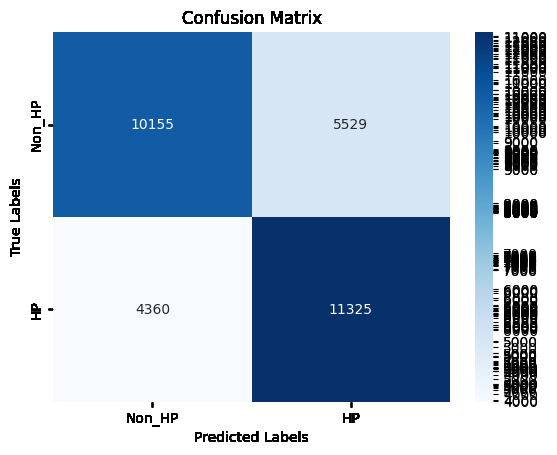

In [32]:
for fold in range(0, CONFIG['n_fold']):
    print(f"{y_}====== Fold: {fold} ======{sr_}")
    run = wandb.init(project='HP_results_Jira_High_vs_rest_results', 
                     config=CONFIG,
                     job_type='Train',
                     group=CONFIG['group'],
                     tags=[CONFIG['model_name'], f'{HASH_NAME}'],
                     name=f'{HASH_NAME}-fold-{fold}',
                     anonymous='must')
    
    # Create Dataloaders
    train_loader, valid_loader = prepare_loaders(fold=fold)
    
    model = HP_Model(CONFIG['model_name'])
    model.to(CONFIG['device'])
    
    # Define Optimizer and Scheduler
    optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
    scheduler = fetch_scheduler(optimizer)
    
    model, history = run_training(model, optimizer, scheduler,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)
    
    run.finish()
    
    del model, history, train_loader, valid_loader
    _ = gc.collect()
    print()

<h2> Testing Inference </h2>


In [33]:
import warnings,transformers,logging,torch

warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [34]:
test_df = test_hp_df

In [35]:
test_df

,text,label
16484,iiopsecurityinvocationtestcase fails with secu...,0
27086,it seems that we have some jars as part of pdf...,1
51630,release olingo version,0
54583,log cleaner grows buffers when resultmessagesr...,1
59967,hiwith cvs cocoon ive been getting warnings li...,0
...,...,...
76820,error log shows the followingmessage found com...,1
110268,when following the instructions for helloworld...,1
103694,rse server stop over ssh does not work for as ...,1
860,currently there is no way to browse and discov...,0


In [36]:
class HP_TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        samples = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            
        }

        if 'token_type_ids' in inputs:
            samples['token_type_ids'] = inputs['token_type_ids']
        
        return samples

In [37]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])

softmax = nn.Softmax(dim=1)
model = HP_Model(CONFIG['model_name'])

In [38]:
def prepare_test_loader(test_df):    
    test_dataset = HP_TestDataset(test_df, 
                                   tokenizer=CONFIG['tokenizer'], 
                                   max_length=CONFIG['max_length'])
    
    test_loader = DataLoader(test_dataset, 
                             batch_size=CONFIG['valid_batch_size'], 
                             collate_fn=collate_fn, 
                             num_workers=2, 
                             shuffle=False, 
                             pin_memory=True, 
                             drop_last=False)
    return test_loader

test_loader = prepare_test_loader(test_df)

In [39]:
@torch.no_grad()
def inference(test_loader, model, device):
    preds = []
    preds_target = []
    model.eval()
    model.to(device)
    
    bar = tqdm(enumerate(test_loader), total=len(test_loader))
    
    for step, data in bar: 
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        
        output = model(ids, mask)
        y_preds = softmax(torch.tensor(output.to('cpu'))).numpy()
        pred_target = torch.argmax(output, dim=-1).flatten().tolist()
        
        preds.append(y_preds)
        preds_target.append(pred_target) 
    predictions = np.concatenate(preds)
    predictions_label = np.concatenate(preds_target)
    return predictions , predictions_label

In [40]:
deberta_predictions = []
deberta_predictions_labels = []



for fold in range(0, CONFIG['n_fold']):
    print("Fold {}".format(fold))
    
    state = torch.load(f'{HASH_NAME}-Loss-Fold-{fold}.bin')
    model.load_state_dict(state)
    
    prediction, predictions_label = inference(test_loader, model, CONFIG['device'])
    deberta_predictions.append(prediction)
    deberta_predictions_labels.append(predictions_label)
    del state, prediction; gc.collect()
    torch.cuda.empty_cache()
del model

Fold 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1038/1038 [02:15<00:00,  7.66it/s]


Fold 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1038/1038 [02:15<00:00,  7.66it/s]


Fold 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1038/1038 [02:15<00:00,  7.65it/s]


In [41]:
deberta_predictions


[array([[0.29074985, 0.70925015],
        [0.11626299, 0.88373697],
        [0.38554293, 0.61445713],
        ...,
        [0.35343596, 0.64656407],
        [0.9340697 , 0.06593028],
        [0.37947106, 0.62052894]], dtype=float32),
 array([[0.26825866, 0.7317413 ],
        [0.12894434, 0.8710556 ],
        [0.40172157, 0.59827846],
        ...,
        [0.16624694, 0.83375305],
        [0.9533485 , 0.04665144],
        [0.33820325, 0.6617968 ]], dtype=float32),
 array([[0.33369377, 0.6663062 ],
        [0.05466087, 0.94533914],
        [0.37684846, 0.62315154],
        ...,
        [0.23544359, 0.7645564 ],
        [0.93943954, 0.06056045],
        [0.4617165 , 0.5382835 ]], dtype=float32)]

In [42]:
predictions = np.mean(deberta_predictions, axis=0)
predictions

array([[0.2975674 , 0.7024326 ],
       [0.09995607, 0.9000439 ],
       [0.38803765, 0.6119624 ],
       ...,
       [0.25170884, 0.7482912 ],
       [0.94228595, 0.05771406],
       [0.39313027, 0.60686976]], dtype=float32)

In [43]:
len(predictions)

16608

In [44]:
predictions

array([[0.2975674 , 0.7024326 ],
       [0.09995607, 0.9000439 ],
       [0.38803765, 0.6119624 ],
       ...,
       [0.25170884, 0.7482912 ],
       [0.94228595, 0.05771406],
       [0.39313027, 0.60686976]], dtype=float32)

In [45]:
test_df["prediction_0"] = predictions[:, 0] 

In [46]:
test_df["prediction_1"] = predictions[:, 1] 

In [47]:
for i in range(0, CONFIG['n_fold']):

    test_df[f"prediction_label_fold_{i}"] = deberta_predictions_labels[i]


In [48]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2
16484,iiopsecurityinvocationtestcase fails with secu...,0,0.297567,0.702433,1,1,1
27086,it seems that we have some jars as part of pdf...,1,0.099956,0.900044,1,1,1
51630,release olingo version,0,0.388038,0.611962,1,1,1
54583,log cleaner grows buffers when resultmessagesr...,1,0.379286,0.620714,1,0,1
59967,hiwith cvs cocoon ive been getting warnings li...,0,0.612592,0.387408,0,0,0
...,...,...,...,...,...,...,...
76820,error log shows the followingmessage found com...,1,0.468098,0.531902,1,1,1
110268,when following the instructions for helloworld...,1,0.040368,0.959632,1,1,1
103694,rse server stop over ssh does not work for as ...,1,0.251709,0.748291,1,1,1
860,currently there is no way to browse and discov...,0,0.942286,0.057714,0,0,0


In [49]:
len(test_df)

16608

In [50]:
test_df['Max'] = test_df[['prediction_0','prediction_1']].idxmax(axis=1)

In [51]:
test_df["pred"] = test_df['Max'].apply(lambda x: x.replace("prediction_0", "0"))

In [52]:
test_df["pred"] = test_df['pred'].apply(lambda x: x.replace("prediction_1", "1"))


In [53]:
test_df["pred"] = test_df["pred"].astype(int)

In [54]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2,Max,pred
16484,iiopsecurityinvocationtestcase fails with secu...,0,0.297567,0.702433,1,1,1,prediction_1,1
27086,it seems that we have some jars as part of pdf...,1,0.099956,0.900044,1,1,1,prediction_1,1
51630,release olingo version,0,0.388038,0.611962,1,1,1,prediction_1,1
54583,log cleaner grows buffers when resultmessagesr...,1,0.379286,0.620714,1,0,1,prediction_1,1
59967,hiwith cvs cocoon ive been getting warnings li...,0,0.612592,0.387408,0,0,0,prediction_0,0
...,...,...,...,...,...,...,...,...,...
76820,error log shows the followingmessage found com...,1,0.468098,0.531902,1,1,1,prediction_1,1
110268,when following the instructions for helloworld...,1,0.040368,0.959632,1,1,1,prediction_1,1
103694,rse server stop over ssh does not work for as ...,1,0.251709,0.748291,1,1,1,prediction_1,1
860,currently there is no way to browse and discov...,0,0.942286,0.057714,0,0,0,prediction_0,0


In [55]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_df["label"].values, test_df["pred"].values)

print(cf_matrix)

[[5659 2675]
 [1999 6275]]


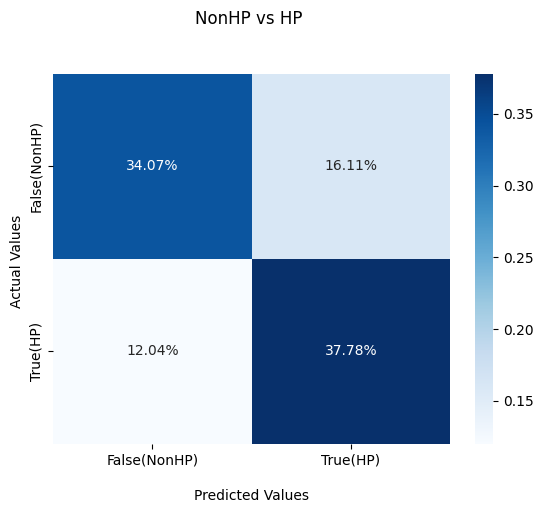

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('NonHP vs HP \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False(NonHP)','True(HP)'])
ax.yaxis.set_ticklabels(['False(NonHP)','True(HP)'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [57]:
from sklearn.metrics import classification_report


print(classification_report(test_df["label"].values, test_df["pred"].values))

              precision    recall  f1-score   support

           0       0.74      0.68      0.71      8334
           1       0.70      0.76      0.73      8274

    accuracy                           0.72     16608
   macro avg       0.72      0.72      0.72     16608
weighted avg       0.72      0.72      0.72     16608

